## **1. Introduction**


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import kruskal
from scipy.stats import chi2_contingency 
from scipy.stats import median_test
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from tqdm import tqdm
import os
import warnings
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier  # Ensemble classifiers for classification tasks.
from sklearn.neighbors import KNeighborsClassifier 
import xgboost as xgb
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier  
from sklearn.ensemble import StackingClassifier  
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
import shap

/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.float_format", "{:.2f}".format)  
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks
pd.set_option('display.width', 1000)  # Set a wider display
warnings.simplefilter(action='ignore', category=FutureWarning)

## **2. Dataset Overview**


In [3]:
# Load your dataset
data = pd.read_excel('fintech_sample_fintech_transactions.xls')  

In [4]:
# check the dimensions of the data
n_rows, n_cols = data.shape
print(f'There are {n_rows:,} samples and {n_cols} variables in the dataset')

There are 1,000 samples and 14 variables in the dataset


In [5]:
# check the distinct variables in the dataset
print(f'The variables in the data are:')
list(data.columns)

The variables in the data are:


['transaction_id',
 'customer_id',
 'transaction_amount',
 'transaction_type',
 'device_type',
 'location',
 'time_of_day',
 'day_of_week',
 'is_foreign_transaction',
 'is_high_risk_country',
 'previous_fraud_flag',
 'label_code',
 'transaction_time',
 'risk_score']

In [6]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          1000 non-null   object        
 1   customer_id             1000 non-null   object        
 2   transaction_amount      1000 non-null   float64       
 3   transaction_type        1000 non-null   object        
 4   device_type             1000 non-null   object        
 5   location                1000 non-null   object        
 6   time_of_day             1000 non-null   object        
 7   day_of_week             1000 non-null   object        
 8   is_foreign_transaction  1000 non-null   int64         
 9   is_high_risk_country    1000 non-null   int64         
 10  previous_fraud_flag     1000 non-null   int64         
 11  label_code              1000 non-null   int64         
 12  transaction_time        1000 non-null   datetime6

In [7]:
# Define target variable
target_var = 'label_code'

# Define list of categorical variables
categorical_vars = ['customer_id', 'transaction_type', 'device_type','location',
                    'is_foreign_transaction', 'is_high_risk_country','previous_fraud_flag', 
                    'time_of_day', 'day_of_week']


# Convert the columns to categorical type
data[categorical_vars] = data[categorical_vars].astype('category')

# Define list of numerical variables
numerical_vars = ['transaction_amount', 'risk_score']

# # Convert the columns to numerical type
# data[numerical_vars] = data[numerical_vars].astype('float64')

# Define list of temporal variables
temporal_vars = 'transaction_time'

In [8]:
# Show distinct values in categorical variables
for var in categorical_vars + ["label_code"]:
    print(f"{var}:")
    len_distinct = data[var].nunique()
    print(f"There are {len_distinct} distinct values in {var}")
    if len_distinct > 10:
        print(f"Some distinct values in {var} are: {list(data[var].unique())[:5]}") 
    else:
        print(list(data[var].unique()))
    print()

customer_id:
There are 101 distinct values in customer_id
Some distinct values in customer_id are: ['CUST1092', 'CUST1021', 'CUST1100', 'CUST1099', 'CUST1014']

transaction_type:
There are 4 distinct values in transaction_type
['Online', 'POS', 'ATM', 'Transfer']

device_type:
There are 4 distinct values in device_type
['Mobile', 'ATM Machine', 'POS Terminal', 'Web']

location:
There are 5 distinct values in location
['Abuja', 'Lagos', 'Ibadan', 'Kano', 'Port Harcourt']

is_foreign_transaction:
There are 2 distinct values in is_foreign_transaction
[0, 1]

is_high_risk_country:
There are 2 distinct values in is_high_risk_country
[1, 0]

previous_fraud_flag:
There are 2 distinct values in previous_fraud_flag
[0, 1]

time_of_day:
There are 4 distinct values in time_of_day
['Afternoon', 'Evening', 'Morning', 'Night']

day_of_week:
There are 7 distinct values in day_of_week
['Fri', 'Tue', 'Wed', 'Sun', 'Thu', 'Mon', 'Sat']

label_code:
There are 2 distinct values in label_code
[1, 0]



In [9]:
# Show basic statistics of numerical variables
data[numerical_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_amount,1000.00,72.60,73.35,-17.07,21.04,50.38,102.79,608.38
risk_score,1000.00,0.75,0.82,-0.29,0.20,0.49,1.04,8.57


In [10]:
# Check for possible missing data
data.isnull().any().any()

False

In [11]:
# Check for duplicate data
data.duplicated().any()

False

## **3. Exploratory Data Analysis**

### **3.1 Target Variable**

#### **3.1.1 Class Distribution**

In [33]:
# Map numeric labels to tags
label_map = {0: "No Fraud", 1: "Fraud"}

# Map target variable
data["Label"] = data[target_var].map(label_map)

In [34]:
# Get counts of each label
label_count = data["Label"].value_counts()

# Shows class distribution
label_count.apply(lambda x: f'{x:,}')

Label
No Fraud    829
Fraud       171
Name: count, dtype: object

In [16]:
# Create a donut chart
fig = px.pie(
    values=label_count.values,
    names=label_count.index,
    title="Fraud vs No Fraud Distribution",
    hole=0.3
)

# Show counts + percentages on chart
fig.update_traces(textinfo="percent+label")

fig.show()

### **3.2 EDA for Numerical Variables**

#### **3.2.1 Univariate Analysis**

In [17]:
# function to get basic stats of numerical variables
def distrib_stats(data, column):

    mean = data[column].mean()
    median = data[column].median()

    skewness = data[column].skew()
    kurtosis = data[column].kurtosis()

    return {'mean':mean, 'median': median, 'skewness': skewness, 'kurtosis': kurtosis}

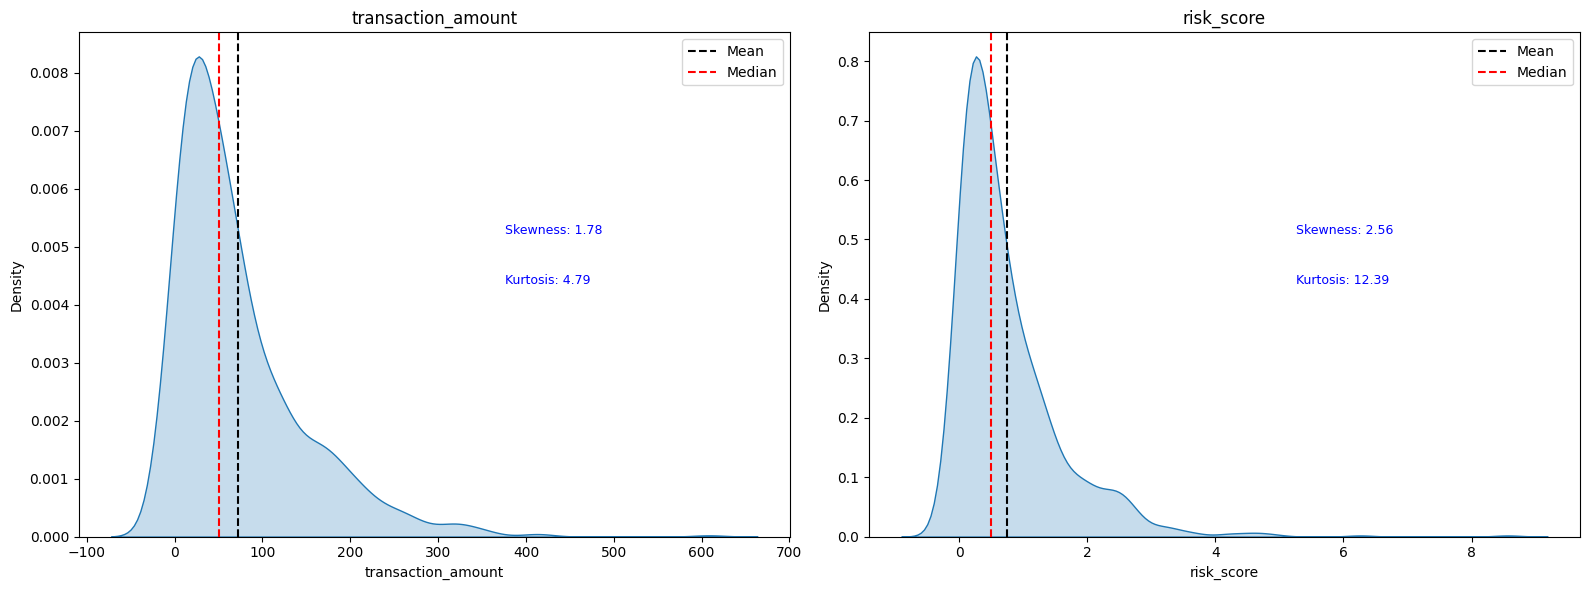

In [18]:
# Plot the distribution of numerical variables 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

for idx, col in enumerate(numerical_vars):
    ax = axes[idx]

    # KDE plot with mean and median lines
    sns.kdeplot(data=data, x=col, ax=ax, fill=True)
    stats = distrib_stats(data, col)

    # Add mean and median lines
    ax.axvline(x=stats['mean'], color='black', linestyle='--', label='Mean')
    ax.axvline(x=stats['median'], color='red', linestyle='--', label='Median')

    # Annotate skewness and kurtosis
    ax.text(0.6, 0.6, f"Skewness: {stats['skewness']:.2f}", transform=ax.transAxes, size=9, color='blue')
    ax.text(0.6, 0.5, f"Kurtosis: {stats['kurtosis']:.2f}", transform=ax.transAxes, size=9, color='blue')

    ax.legend()
    ax.set_title(f"{col}")

# Adjust layout
plt.tight_layout()
plt.show()


##### **From the basic analysis we can infer the following:**

#### **3.2.2 Multivariate Analysis**

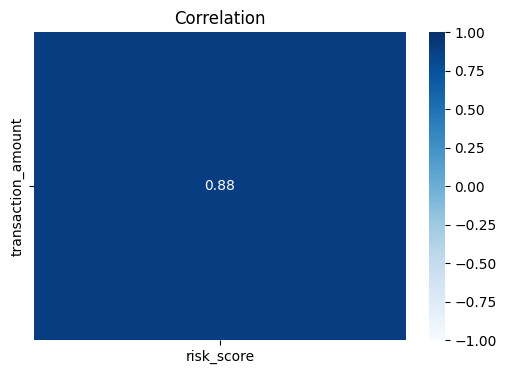

In [31]:
# Visualize correlation matrix
corr_value = data[numerical_vars].corr().iloc[0, 1]

plt.figure(figsize=(6, 4))
sns.heatmap([[corr_value]], annot=True, cmap="Blues", vmin=-1, vmax=1, cbar=True,
            xticklabels=[numerical_vars[1]], yticklabels=[numerical_vars[0]])

plt.title("Correlation")
plt.show()


#### **Insights from the Correlation Matrix:**

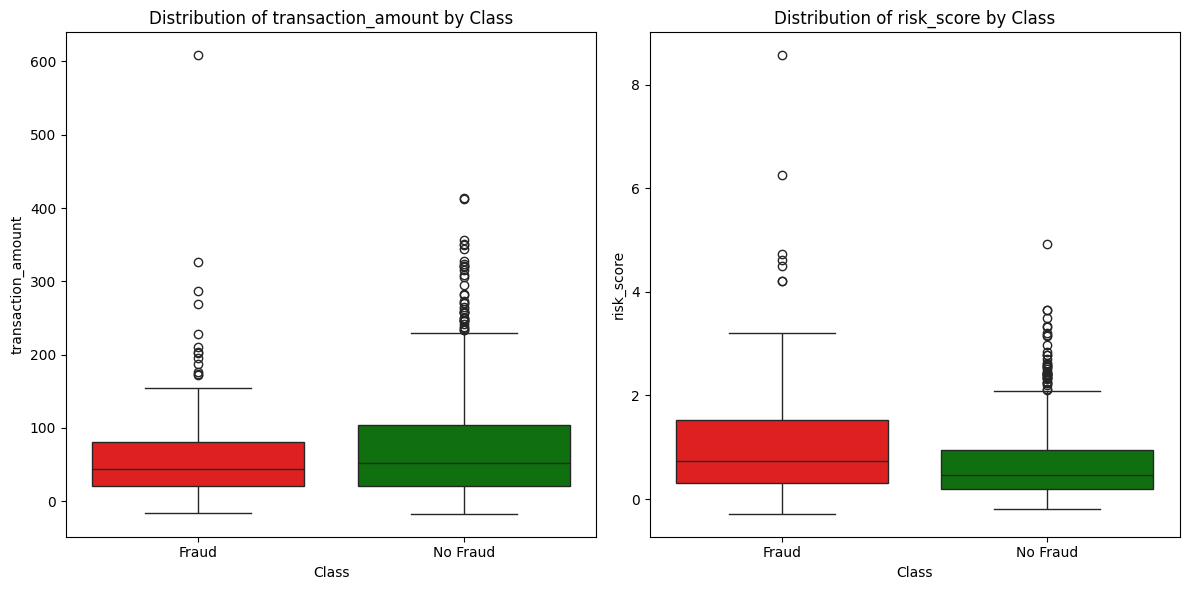

In [36]:
# Plot numerical feature distribution by class

n_rows, n_cols = 1, len(numerical_vars)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * len(numerical_vars), 6))

# Flatten the axes array to iterate over it 
axes = axes.flatten()

# Define custom colors
custom_palette = {"No Fraud": "green", "Fraud": "red"}

# Loop through numerical columns and create boxplots
for i, col in enumerate(numerical_vars):
    sns.boxplot(
        data=data, 
        x="Label", 
        y=col, 
        ax=axes[i], 
        palette=custom_palette
    )
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel(col)
    axes[i].set_title(f"Distribution of {col} by Class")

plt.tight_layout()
plt.show()


#### **Insights from the Boxplots:**

In [37]:
len(categorical_vars)

9

### **3.3 EDA for Categorical Variables**

#### **3.3.1 Univariate Analysis**

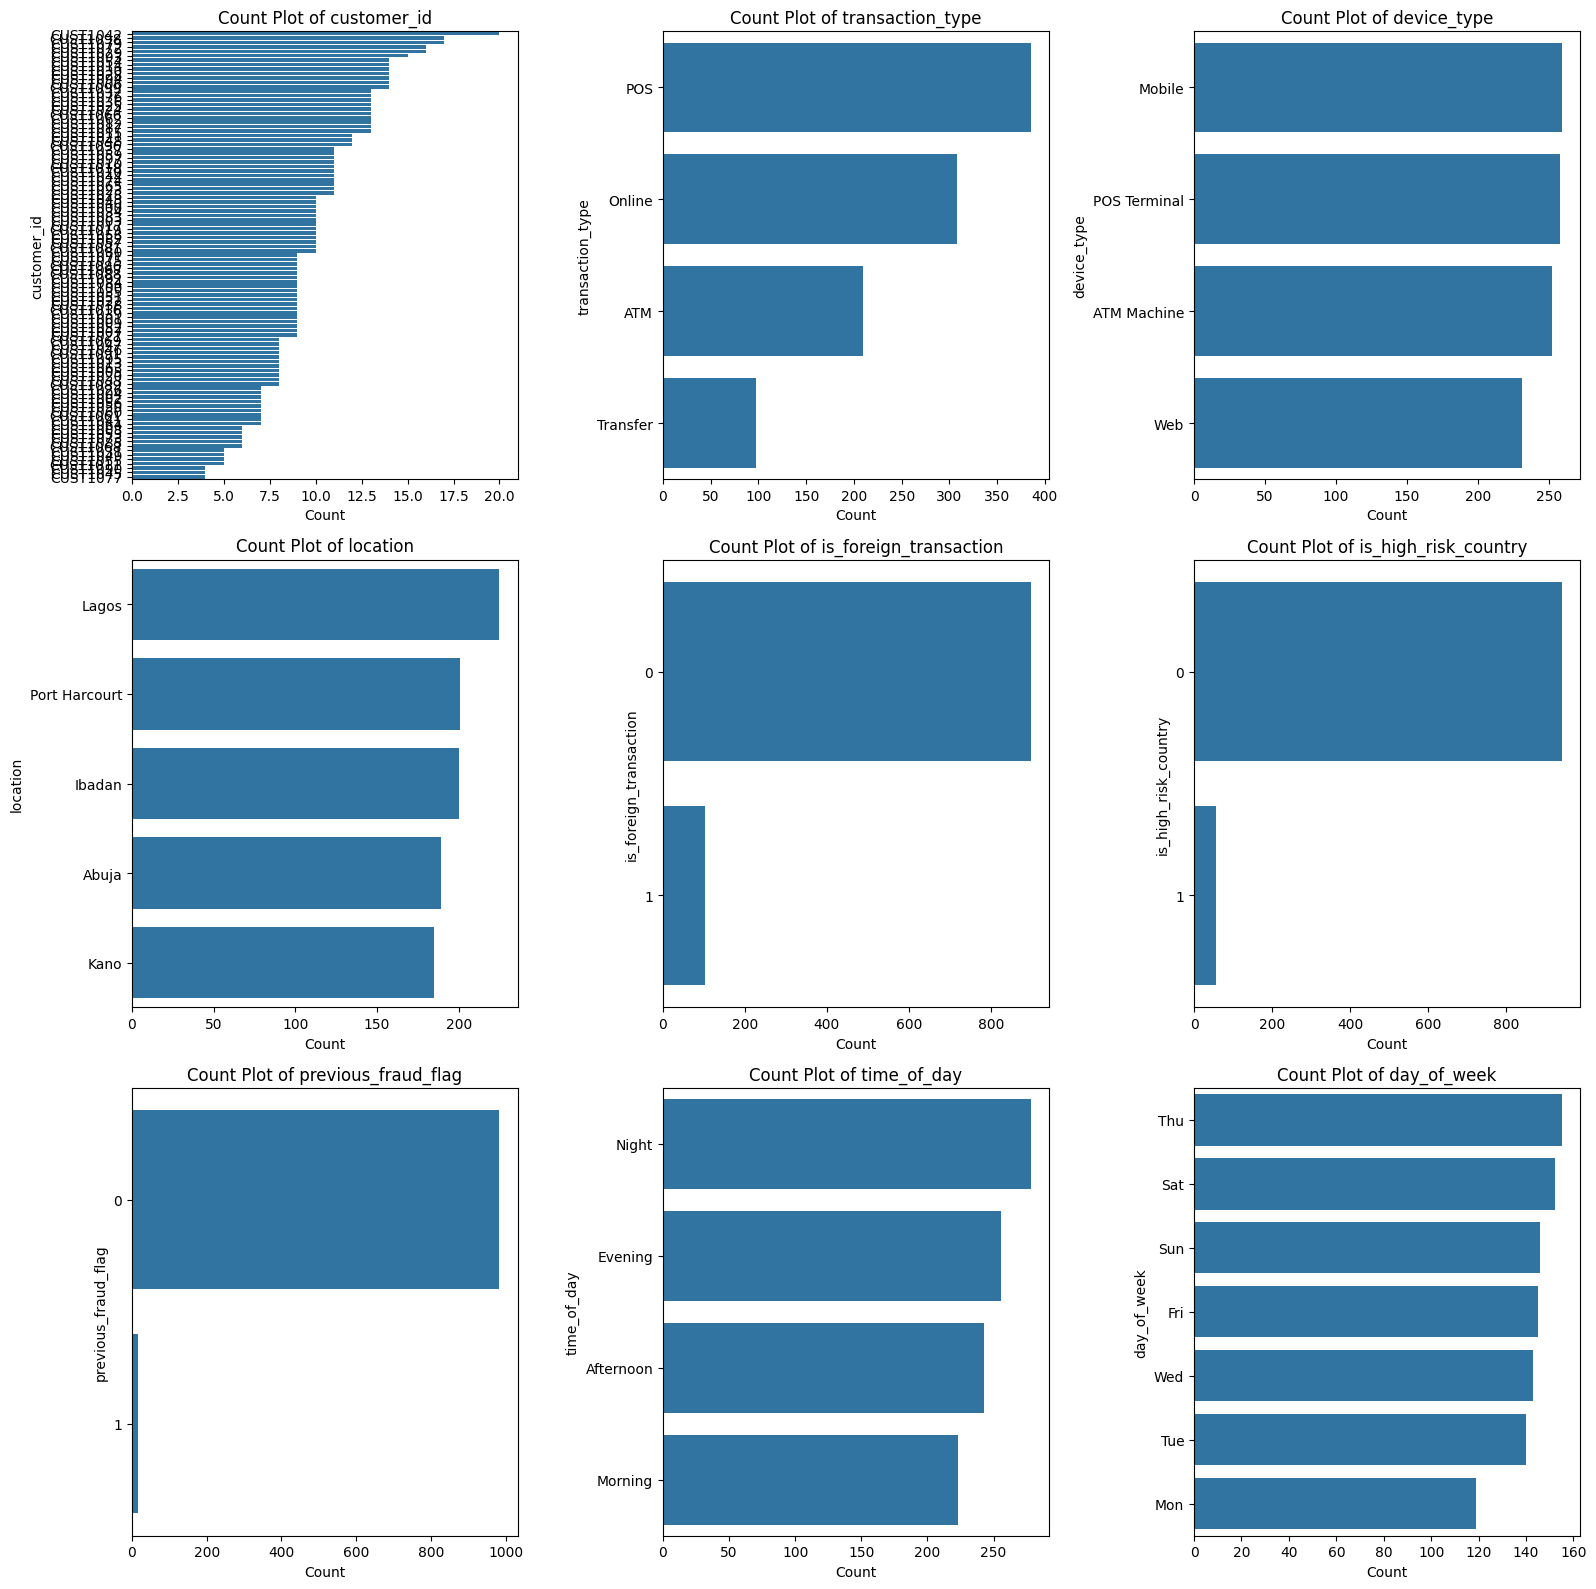

In [38]:
n_rows, n_cols = 3, 3  # Adjust as needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))  
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    
    category_count = data[var].value_counts()
    sns.countplot(y=data[var], order=category_count.index, ax=axes[i])
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(var)
    axes[i].set_title(f"Count Plot of {var}")

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **3.3.2 Multivariate Analysis**

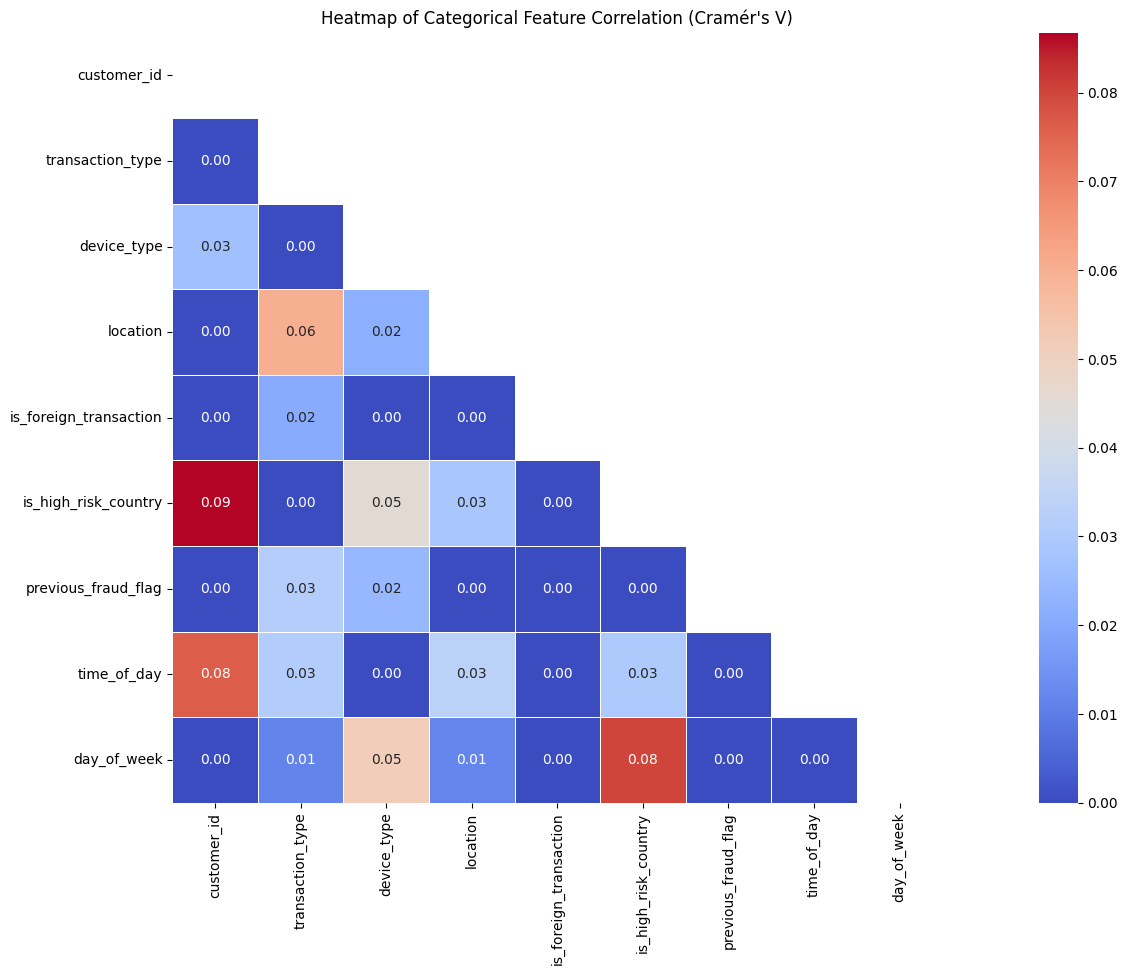

In [39]:
# Plot correlation heatmap of categorical variables 
# Using Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # Not enough categories to compute correlation
    
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1)) if n > 1 else 0
    rcorr = r - ((r-1)**2) / (n-1) if n > 1 else 1
    kcorr = k - ((k-1)**2) / (n-1) if n > 1 else 1
    
    denominator = min((kcorr - 1), (rcorr - 1))
    if denominator <= 0:
        return np.nan
    
    return np.sqrt(phi2corr / denominator)


# Compute Cramér's V matrix
corr_matrix = pd.DataFrame(
    np.zeros((len(categorical_vars), len(categorical_vars))),
    index=categorical_vars,
    columns=categorical_vars
)

for col1 in categorical_vars:
    for col2 in categorical_vars:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot
plt.figure(figsize=(25, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Heatmap of Categorical Feature Correlation (Cramér's V)")
plt.show()

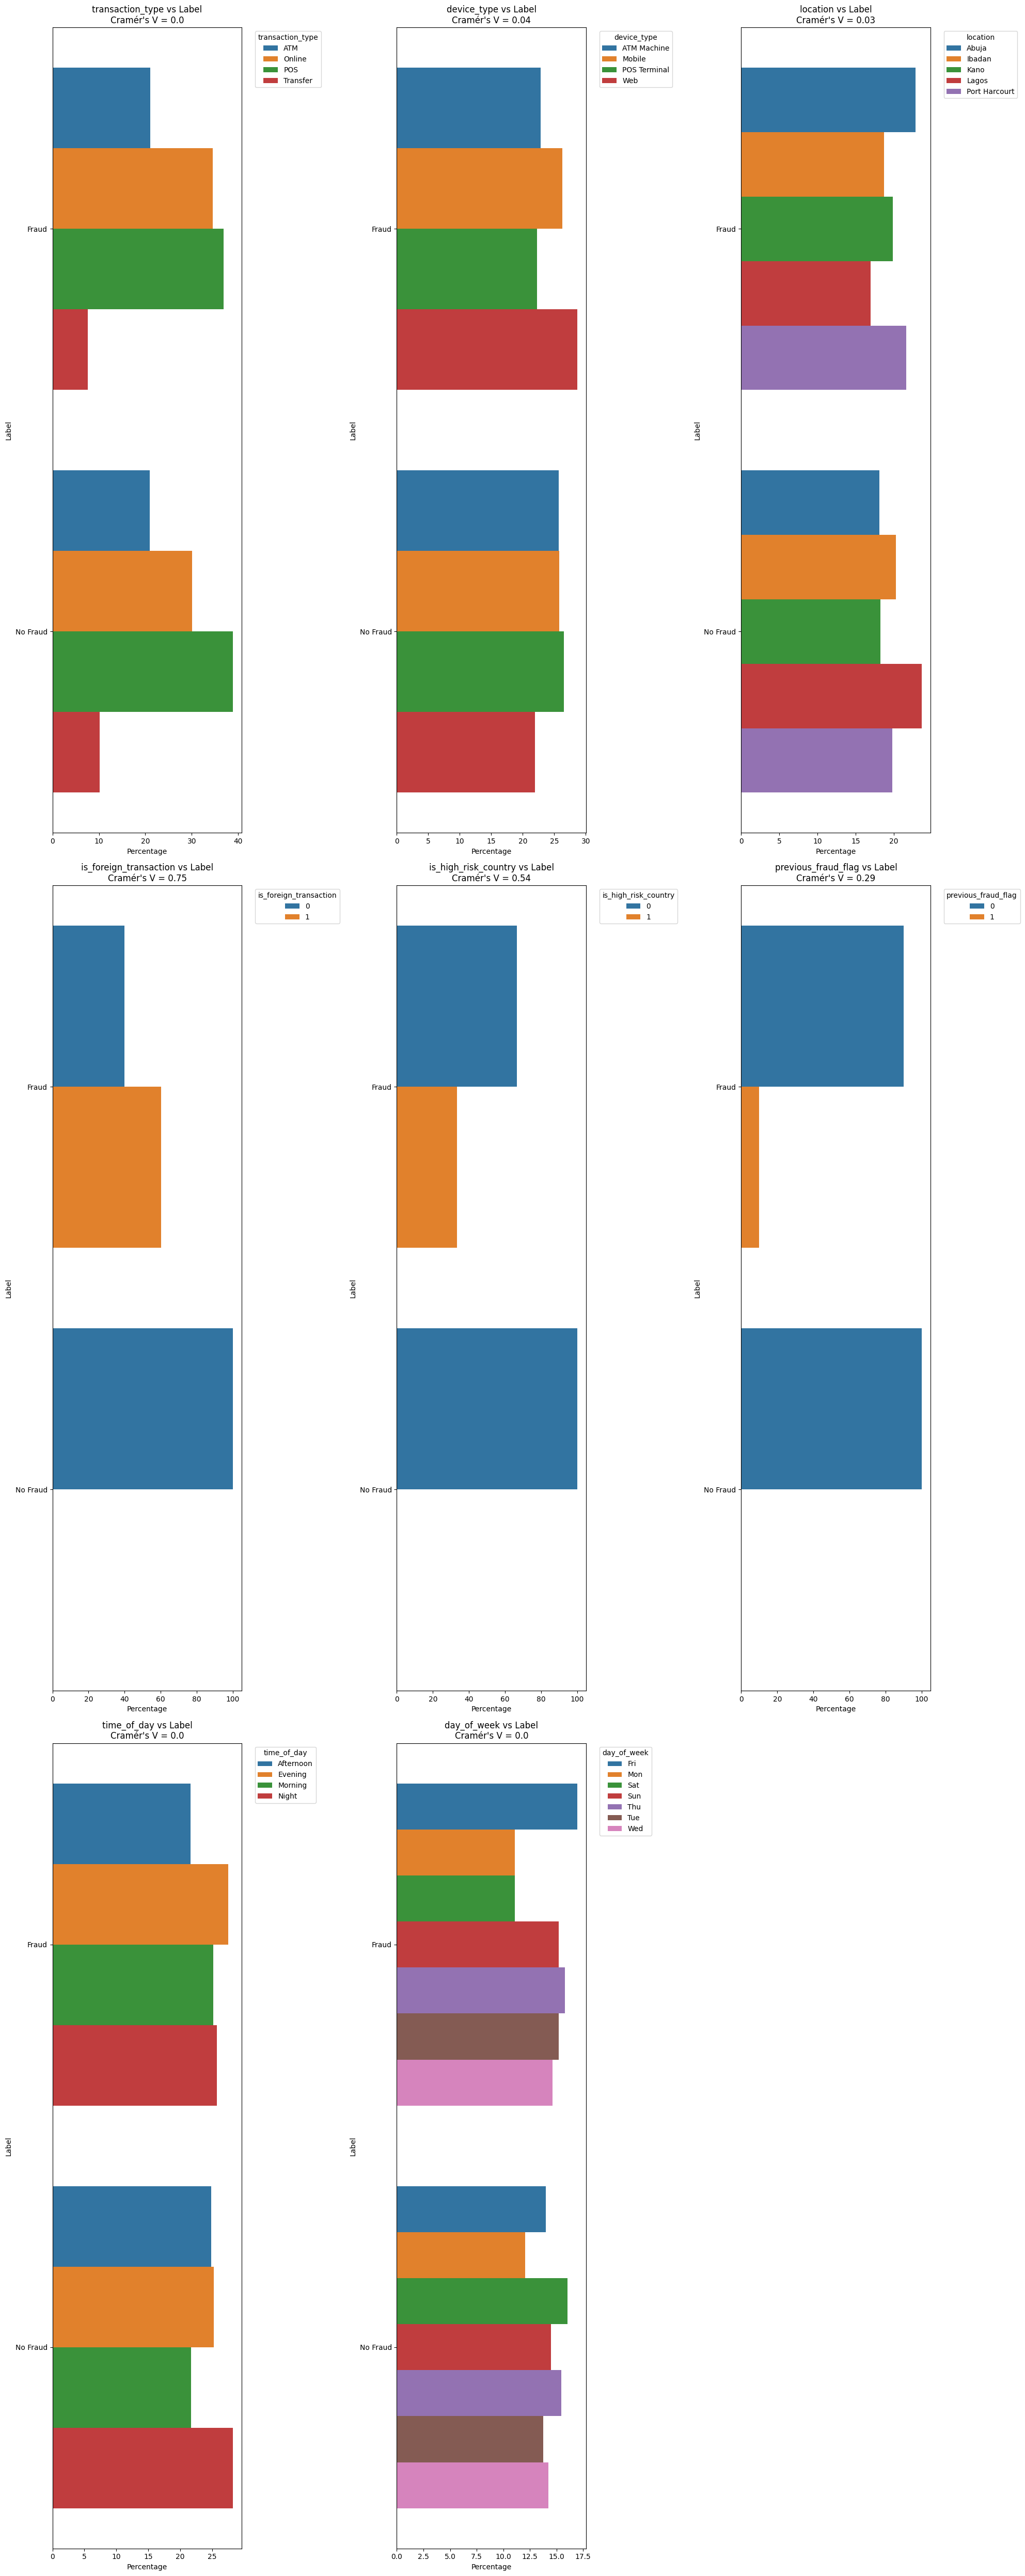

In [41]:
# Plot relationship between categorical variables and target

# Function to calculate corrected Cramér's V
def cramers_v(feature):
    contingency_table = pd.crosstab(data[feature], data['Label'])
    chi2 = chi2_contingency(contingency_table, correction=False)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape

    # Data imbalance correction
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)

    cramers_v = np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))
    return contingency_table, cramers_v  

# Define the grid size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 50))  # 3 rows, 3 columns
axes = axes.flatten()

# Iterate through categorical variables
for i, feature in enumerate(categorical_vars[1:]):
    contingency_table, cramers_value = cramers_v(feature)

    # Row-wise normalization to show class proportions per feature value
    contingency_table_percent = contingency_table.div(contingency_table.sum(axis=0)) * 100
    contingency_table_percent = contingency_table_percent.reset_index()

    # Reshape for stacked bar plot 
    df_stacked = contingency_table_percent.melt(id_vars=[feature], var_name='Label', value_name='percentage')

    # Select subplot
    ax = axes[i]

    # # Plot the clustered bar chart
    sns.barplot(data=df_stacked, y='Label', x='percentage', hue=feature, ax=ax)

    # Annotate Cramér's V value inside title
    ax.set_title(f"{feature} vs Label\nCramér's V = {round(cramers_value, 2)}")
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Label')
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save
plt.tight_layout()
plt.show()

In [ ]:
# Group by customer_id and calculate fraud percentage
fraud_table = (
    data.groupby("customer_id")[target_var]
    .mean()  # mean of 0/1 gives fraud rate
    .reset_index()
)

# Convert to percentage
fraud_table["%Fraud"] = fraud_table[target_var] * 100

# Drop the original target column
fraud_table = fraud_table.drop(columns=[target_var])

# Sort by %Fraud (descending) and show top 10
top_fraud_customers = fraud_table.sort_values("%Fraud", ascending=False).head(10)

top_fraud_customers

,customer_id,%Fraud
8,CUST1008,66.67
33,CUST1033,62.50
53,CUST1053,50.00
73,CUST1073,50.00
92,CUST1092,44.44
0,CUST1000,40.00
12,CUST1012,38.46
46,CUST1046,37.50
70,CUST1070,36.36
6,CUST1006,35.71


### **Insights from Contingency table plot and Cramer's V evlaluation:**

### **3.4 Summary: Infering Feature Importance for EDA**

#### **1. Expected High Importance:** 
These features consistently showed strong discrimination between classes, had significant variance, or strong correlation patterns in the EDA.

| Feature                                | Reason for Expected High Importance                                                                                                                                                                            |
| -------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `Flow Duration`                        | Very long or very short durations common in specific threat types. Distribution and boxplot analysis supported this. Uncorrelated with other features and PCA coefficient also infers significant relevance.                                                                                    |
| `Magnitude`, `Radius`, `Covariance`, `Variance`, `Weight` | Clear separation across different traffic types in boxplots and distribution plots. Significant spikes for some attack classes.                                                                                                |                                                                                                            |
| `IAT`                        | Strong variance between certain classes as per boxplots; captures delay patterns associated with DDOS, DOS and Mirai attacks compared to other threat types and PCA coefficient also infers significant relevance.                                                                                                                                                                        |

#### **2. Expected Medium Importance:** 
These features showed some class distinction or moderate spread, but had less consistent behavior or partial overlap between classes.


| Feature                              | Reason for Expected Medium Importance                                                                       |
| ------------------------------------ | -------------------------------------------------------------------------------------------------- |
| `Header Length`             | Very short or long lengths; boxplot shows variability across threat types, especially for Brute Force. Medium correlations with a number of features and lower PCA coefficients |
| `Duration`             | Variability across threat types, especially for DOS and DDOS attacks. Medium correlations and high PCA coefficient|
| `Protocol`                           | Some differentiation across attack types but also shared by many benign flows.                     |
| `Rate/SRate`           | Perfectly correlated. Strongly skewed in attack flows vs benign, especially in Mirai and DDoS-related flows. Could be useful in determing these threat types|
| ` Tot sum` `Min`, `Max`, `AVG`, `Tot size` `Number`| Packet aggregate features were insightful for some classes. Beningn and Spoofing types typically seem to have higher aggregates|
| `ACK Flag Cnt`, `HTTPS` `TCP`      | Variability metrics showed moderate separation but not consistently strong across classes. Could be useful in distincting benign flows           |
| `Syn Count`, `URG Count` `RST Count`| Moderate variation but correlated with other packet counts; useful but redundant with already high-importance features.         |


#### **3. Expected Low Importance:** 
These features showed little to no variation, highly sparse values, or very similar distributions across classes.

| Feature                                          | Reason for Expected Low Importance                                                                    |
| ------------------------------------------------ | -------------------------------------------------------------------------------------------- |
| `fin_flag_number`, `syn_flag_number`, `rst_flag_number`, `psh_flag_number`, `ece_flag_number`,`cwr_flag_number`| Always zero or near-zero in both benign and malicious flows.                                 |
| `Drate`, `HTTP`, `SSH`, `UDP`, `ICMP` `ARP`, `IPV`, `LLC`               | Same pattern—low variability, mostly constant values. Sparse and non-informative.                                             |
| `Ack Count`, `Fin Count`                           | Sparse or zero-heavy distributions; very few flows had meaningful counts with very low variations.                |
| `STD`                               | Very low variance observed in boxplots; same values across classes.                          |
| `DNS`, `SMTP` `IRC`, `DHCP` `              | Mostly constant or zero. non-informative.   

## **4. Data Preprocessing**

The data preprocessing steps would include data cleaning based on some of the issues we already higlighted in the data that might affect our predictive analytics. We would also transform the data to the required formats expected by predictive models. We would not aggregate features in our feature engineering step, as as that defeats the aim of identifying the sperate contribution and relevance of the original features.

Some of the issues identified from the data via EDA includes, non normality of numerical features, outliers and extreme values, class imbalance and multi collinearity.
We are going to apply the categorical label encoding to transform the the catgorical variables into features and apply weighted categorical cross entropy to mitigate the effect of data imblance. While the numerical variables might benefit from some standardization to deal with the extreme values and ranges, this wouldn't be mandatory as we are using tree based models for predictive analytics, which are less affected by non normality, extreme values and ranges.

### **4.1. Feature Selection**

While we would use advanced explainable AI methods to determine the global importance of some of the features, we can already identify features with very little or no distinguishing attributes to our model, mostly because they are either highly correlated to other features or have very low variability across classes. We would remove such features to optimize the dimensionality of our data.

In [44]:
df = data.copy()

In [46]:
categorical_vars

['customer_id',
 'transaction_type',
 'device_type',
 'location',
 'is_foreign_transaction',
 'is_high_risk_country',
 'previous_fraud_flag',
 'time_of_day',
 'day_of_week']

In [ ]:
# high_corr_vars = ['transaction_amount', 'risk_score']
# low_variance_vars = ['transaction_type', 'device_type', 'location', 'day_of_week', 'time_of_day']
# df.drop(high_corr_vars+low_variance_vars, axis=1, inplace=True)

In [ ]:
# # Remove dropped variables from variable list
# for var in high_corr_vars+low_variance_vars:
#     if var in numerical_vars:
#         numerical_vars.remove(var)
#     elif var in categorical_vars:
#         categorical_vars.remove(var)
#     else:
#         continue

### **4.2. Feature Transformation**

In [50]:
# label encoding for categorical features
encoders = {}

for var in categorical_vars:
    encoder = LabelEncoder()
    df[var] = encoder.fit_transform(df[var])
    encoders[f'encoder_{var}'] = encoder

In [ ]:
# # to decode an encoded value:
# # original_label = encoders['encoder_category'].inverse_transform([2])[0]

# dict(zip(encoders['encoder_category'].classes_,
#                            range(len(encoders['encoder_category'].classes_))))

In [51]:
# Get Features and target variables
features = df[numerical_vars + categorical_vars]
target = df['label_code']

In [55]:
# Set test and train data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)  

## **5. Predictive Modelling**

### **5.1 Model Selection**

In [56]:
# Define models
models = {
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

# Metrics to evaluate
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Recall": make_scorer(recall_score, average='macro'),
    "Precision": make_scorer(precision_score, average='macro'),
    "F1-score": make_scorer(f1_score, average='macro')
}

# Store scores
results = {metric: [] for metric in scoring}

# Run cross-validation for each model and each metric
print("Cross validation with selected models: \n")
for name, model in models.items():
    print(f"Validating {name}...")
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=4, n_jobs=-1)
        results[metric_name].append(scores.mean())

Cross validation with selected models: 

Validating RandomForest...
Validating XGBoost...


/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fr

Validating LightGBM...
[LightGBM] [Info] Number of positive: 103, number of negative: 497[LightGBM] [Info] Number of positive: 103, number of negative: 497
[LightGBM] [Info] Number of positive: 102, number of negative: 498

[LightGBM] [Info] Number of positive: 103, number of negative: 497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52

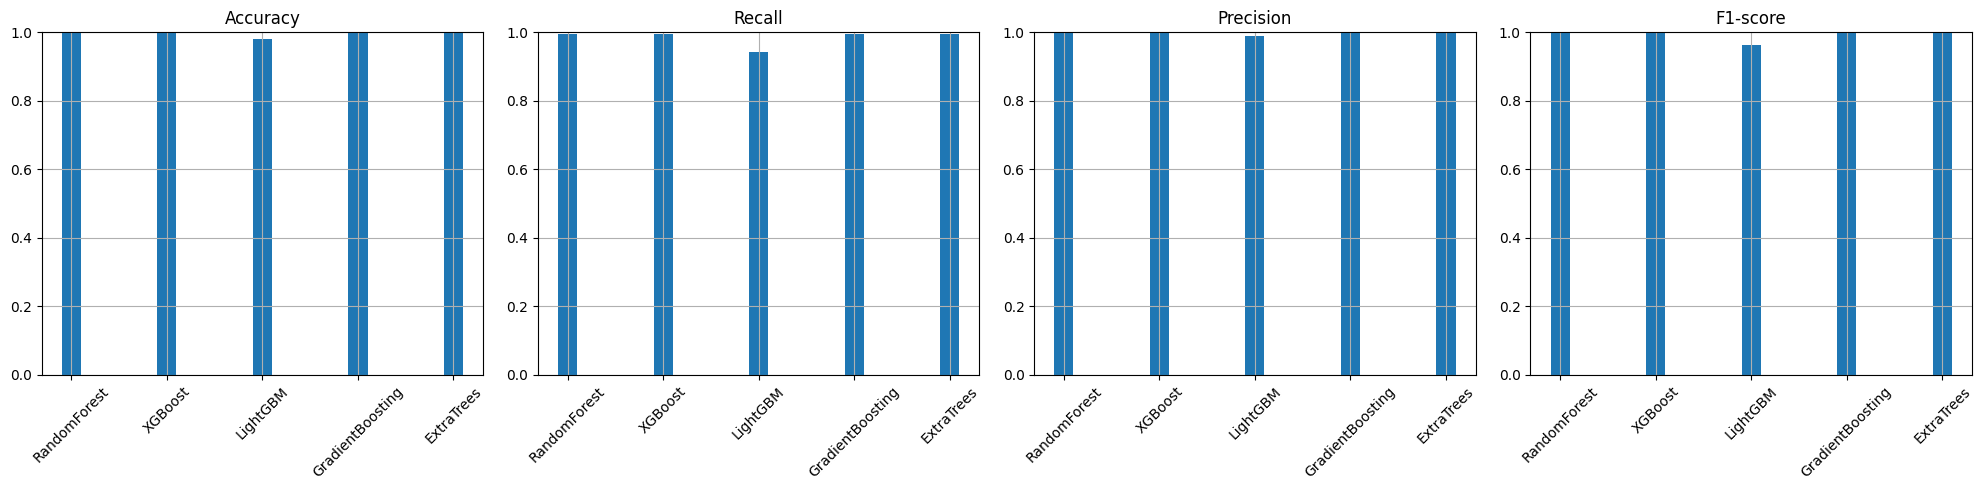

In [ ]:
# Plotting
alg_labels = list(models.keys())
x = np.arange(len(alg_labels))   # ✅ Fix here
width = 0.2

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1-score"]):
    axs[i].bar(x, results[metric], width, label=metric)
    axs[i].set_title(metric)
    axs[i].set_ylim(0, 1)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(alg_labels, rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### **Model Development**

In [60]:
# Adjust class weights to deal with imbalance
raw_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
scaling_factor = 0.01
scaled_weights = 1 + scaling_factor * (raw_weights - 1)
weight_dict = {i: w for i, w in enumerate(scaled_weights)}

# Apply sample weights to the training data
sample_weights = np.array([weight_dict[i] for i in y_train])

In [61]:
# Train the Gradient Boosting model with instance weights
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier()

### **5.2 Model Evaluation**

In [62]:
# Evaluate model on test set
y_predicted = gb_model.predict(X_test) 
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy:", accuracy)

Accuracy: 1.0


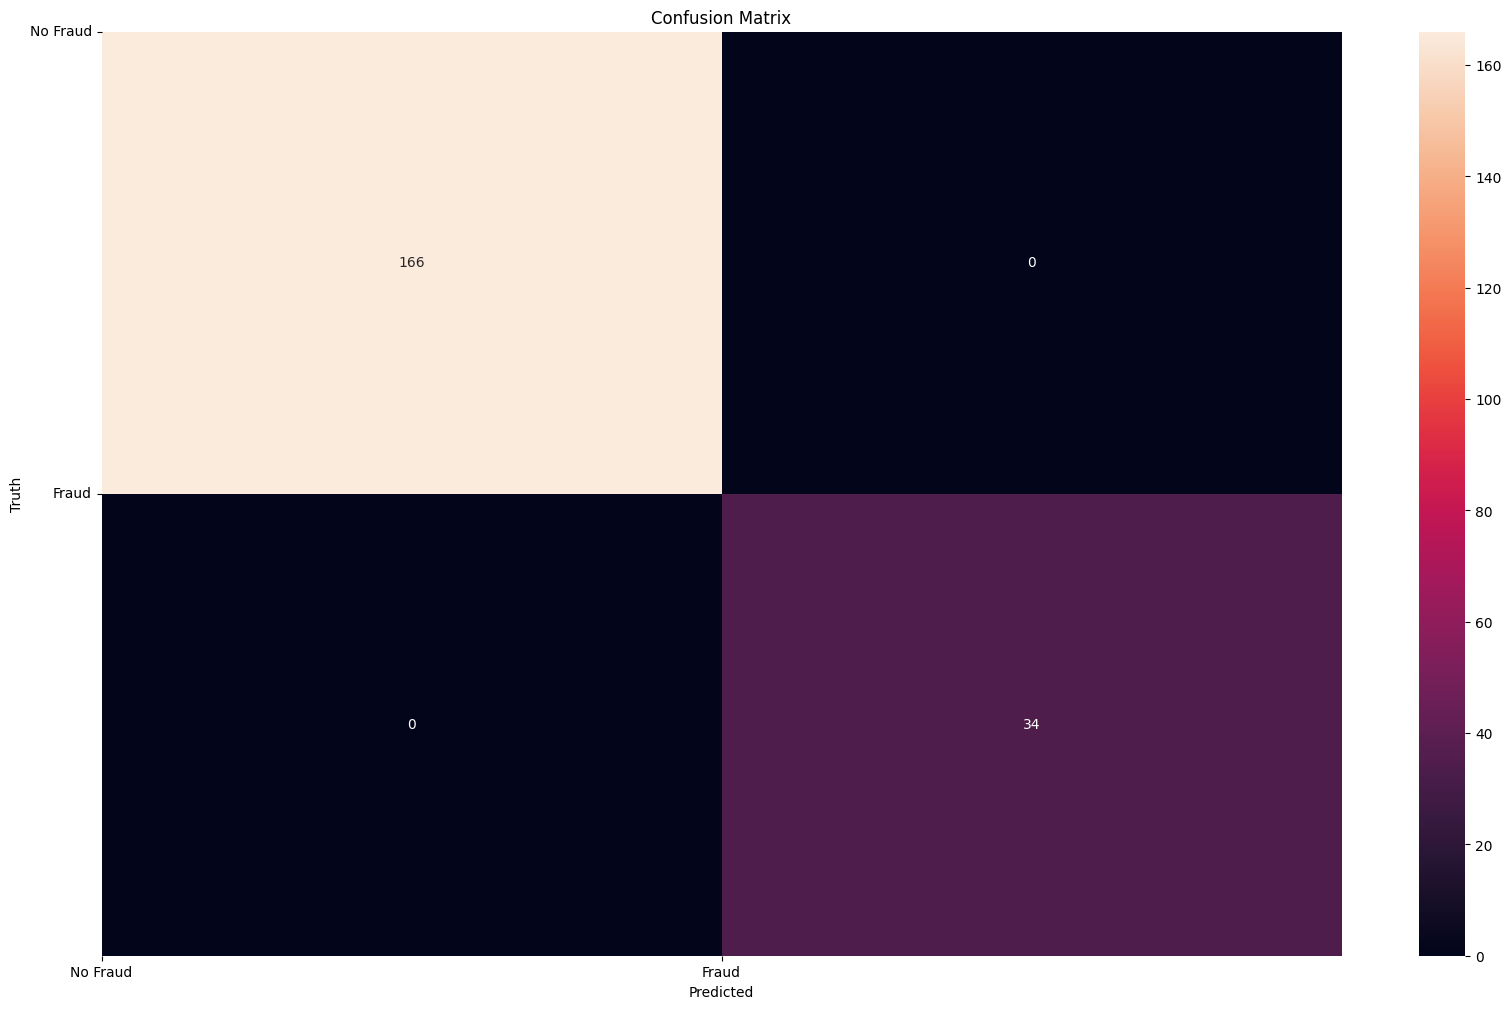

In [64]:
# Display confusion matrix
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(label_map))
plt.xticks(tick_marks, label_map.values())
plt.yticks(tick_marks, label_map.values(), rotation='horizontal')
plt.show()

In [66]:
# Display classification report
print('Classification Report using Adjusted Class Weights  \n', classification_report(y_test, y_predicted,  target_names=label_map.values()))

Classification Report using Adjusted Class Weights  
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00       166
       Fraud       1.00      1.00      1.00        34

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



## **6. Explainability with SHAP**

In [ ]:
# Train an XG Boost model with instance weights
train_data = xgb.DMatrix(X_train, y_train, weight=sample_weights)
test_data = xgb.DMatrix(X_test, y_test)

params = {'objective': 'multi:softmax', 'num_class': len(classes),"tree_method": "hist"}
xgb_model = xgb.train(params, train_data, 100, evals=[(test_data, 'eval')],
                      early_stopping_rounds=10, verbose_eval=False)

#### **6.1.1 Feature Imporatance**

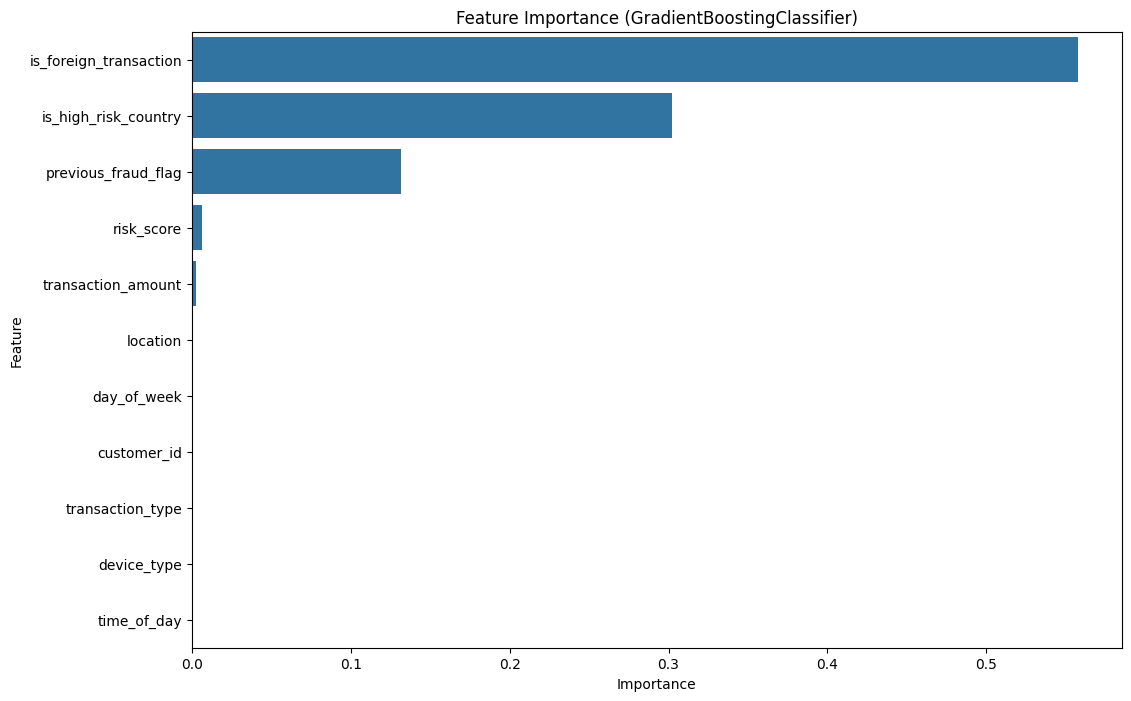

In [69]:
# Assuming you trained with X_train
importances = gb_model.feature_importances_

importance_df = (
    pd.DataFrame({
        'Feature': X_train.columns,   # <- Use the same features gb_model saw
        'Importance': importances
    })
    .sort_values(by='Importance', ascending=False)
)

# Plot
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=importance_df, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (GradientBoostingClassifier)')
plt.show()


#### **6.1.2 Shapley Additive Explanations (SHAP) Summary Plot**

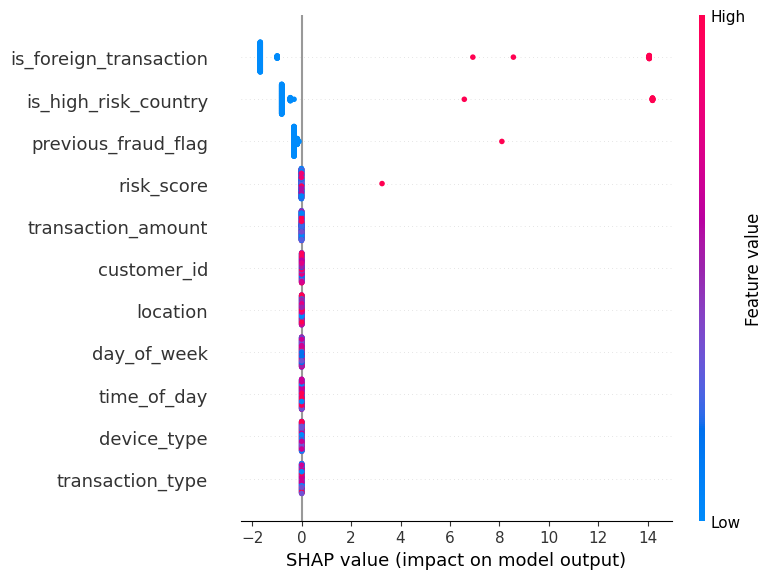

In [70]:
explainer = shap.TreeExplainer(gb_model) 
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, class_names=label_map.keys())